<a href="https://colab.research.google.com/github/bhagyaborade/my_projects/blob/binary_classifier/dogvscat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.QUDQRR_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 376s 633ms/step - accuracy: 0.9283 - loss: 0.1738 - val_accuracy: 0.9764 - val_loss: 0.0661
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 375s 621ms/step - accuracy: 0.9781 - loss: 0.0614 - val_accuracy: 0.9789 - val_loss: 0.0586
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 387s 632ms/step - accuracy: 0.9792 - loss: 0.0558 - val_accuracy: 0.9798 - val_loss: 0.0595
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 385s 637ms/step - accuracy: 0.9805 - loss: 0.0504 - val_accuracy: 0.9794 - val_loss: 0.0566
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 362s 620ms/step - accuracy: 0.9823 - loss: 0.0479 - val_accuracy: 0.9802 - val_loss: 0.0558
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.9809 - loss: 0.0541
Test Accuracy: 0.980223536491394


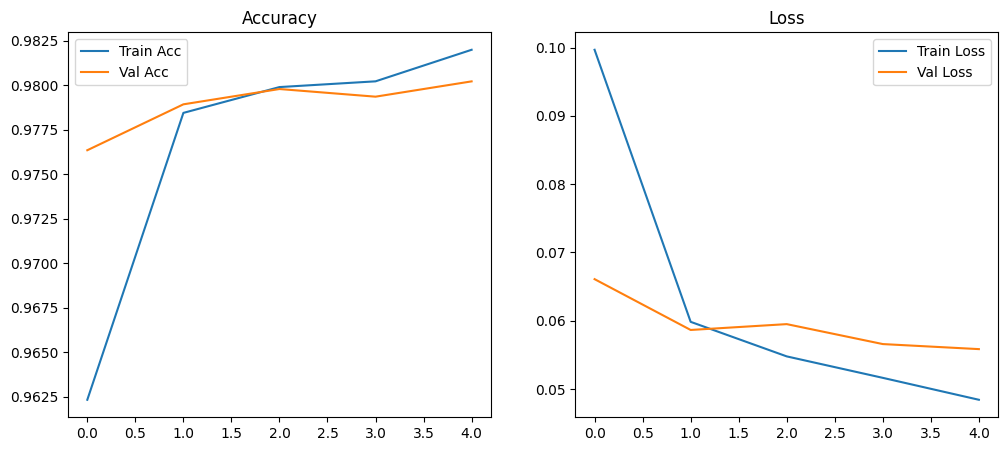

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Dog (0.999)


In [4]:
# 1. Install and import libraries
!pip install -q tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# 2. Load dataset with splits: 80% train, 10% val, 10% test
SPLITS = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
(ds_train, ds_val, ds_test), info = tfds.load(
    'cats_vs_dogs',
    split=SPLITS,
    with_info=True,
    as_supervised=True,
)

# 3. Preprocess: resize, normalize, data augmentation
IMG_SIZE = 160
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    return img, label

def prepare(ds, shuffle=False, augment_data=False):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = prepare(ds_train, shuffle=True, augment_data=True)
val_ds   = prepare(ds_val)
test_ds  = prepare(ds_test)

# 4. Build model with transfer learning (MobileNetV2)
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Train the model
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# 6. Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print('Test Accuracy:', test_acc)

# 7. Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# 8. Predict on custom image
import requests
from PIL import Image
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg"
resp = requests.get(url)
img = Image.open(BytesIO(resp.content)).convert('RGB')
img = img.resize((IMG_SIZE, IMG_SIZE))
x = np.expand_dims(np.array(img)/255.0, axis=0)

pred = model.predict(x)[0][0]
print("Dog" if pred > 0.5 else "Cat", f"({pred:.3f})")


In [5]:
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 160  # Set according to your model

def predict_image_from_url(url):
    try:
        resp = requests.get(url)
        resp.raise_for_status()

        img = Image.open(BytesIO(resp.content)).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        x = np.expand_dims(np.array(img)/255.0, axis=0)
        pred = model.predict(x)[0][0]
        label = "Dog" if pred > 0.5 else "Cat"
        return img, label

    except UnidentifiedImageError:
        return None, "Error: Invalid image"
    except Exception as e:
        return None, f"Error: {str(e)}"


In [6]:
model.save("cats_vs_dogs_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Failed to process image 3: Error: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/a/a3/81_INF_DIV_SSI.jpg


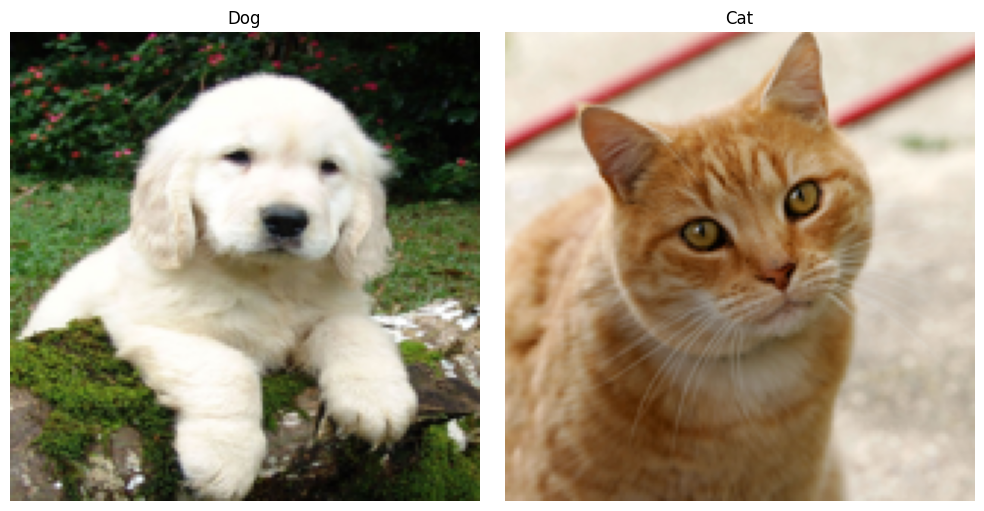

In [7]:
# List of test image URLs
urls = [
    "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg",  # Dog
    "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg",       # Cat
    "https://upload.wikimedia.org/wikipedia/commons/a/a3/81_INF_DIV_SSI.jpg"  # Not an animal
]

# Visualize
plt.figure(figsize=(15, 5))
for i, url in enumerate(urls):
    img, label = predict_image_from_url(url)
    if img:
        plt.subplot(1, len(urls), i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    else:
        print(f"Failed to process image {i + 1}: {label}")

plt.tight_layout()
plt.show()
